### Particle tracking in the Warnow Estuary
#### hydrodynamic filed from GTEM
### March 2018

In [12]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionDiffusionM1, ParcelsRandom
from operator import attrgetter

import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import math
import os

In [13]:
!pip install gdown

In [4]:
import gdown

In [7]:
# Data folder
data_folder = "HR20m_results"
os.makedirs(data_folder, exist_ok=True)

# Download from Google Drive
# It takes a while - it is a subset of Warnow for 01 to 07 March 2018

file_id = "1u2WZO5-FJ3JHTYFO8YFfgBqQp17W9hUC"
filename = "HRO20m.surf.20180301.nc4"
file_path = os.path.join(data_folder, filename)

if not os.path.exists(file_path):
    print(f"Downloading {filename} ...")
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, file_path, quiet=False)
else:
    print(f"{filename} already exists, skipping download.")

print("Hydro file is ready!")

Downloading...
From (original): https://drive.google.com/uc?id=1u2WZO5-FJ3JHTYFO8YFfgBqQp17W9hUC
From (redirected): https://drive.google.com/uc?id=1u2WZO5-FJ3JHTYFO8YFfgBqQp17W9hUC&confirm=t&uuid=4028fc4b-44a7-487b-9546-5f8c9ec37cf8
To: /home/jovyan/HR20m_results/HRO20m.surf.20180301.nc4
100%|██████████| 10.5G/10.5G [02:08<00:00, 81.9MB/s]

Hydro file is ready!


In [8]:
out_file = f"output/warnow_harbor.zarr"

In [14]:
filenames = {
    "U": f"{data_folder}/HRO20m.surf.2018*.nc4",
    "V": f"{data_folder}/HRO20m.surf.2018*.nc4",
}

variables = {
    "U": "uu",
    "V": "vv",
}

dimensions = {}

dimensions['U'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['V'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

filenames['Kh_zonal']      = f"{data_folder}//HRO20m.surf.2018*.nc4"
filenames['Kh_meridional'] = f"{data_folder}//HRO20m.surf.2018*.nc4"

variables['Kh_zonal']      = 'AmC_3d'
variables['Kh_meridional'] = 'AmC_3d'

dimensions['Kh_zonal']      = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['Kh_meridional'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

In [15]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,
                                mesh='flat',
                                interp_method={'U': 'freeslip', 'V': 'freeslip','Kh_zonal':'linear',
                                               'Kh_meridional':'linear'}, allow_time_extrapolation=True)
 
fieldset.add_constant('dres', 10)

In [20]:
pset = ParticleSet.from_line(
    fieldset=fieldset, 
    pclass=JITParticle, 
    start=(704440, 5998425),  # releasing on a line: the start longitude and latitude
    finish=(704760, 5998425), # releasing on a line: the end longitude and latitude
    size=300,
    time=0, #start from the beging of the ds
)

In [21]:
output_file = pset.ParticleFile(name=out_file, outputdt=timedelta(hours=3))
ParcelsRandom.seed(1636)

In [22]:
pset.execute([AdvectionDiffusionM1], 
             runtime=timedelta(days=10), 
             dt=timedelta(minutes=30),
             output_file=output_file)

INFO: Output files are stored in output/warnow_harbor.zarr.
100%|██████████| 864000.0/864000.0 [01:15<00:00, 11387.08it/s]


#### QUICK VIEW

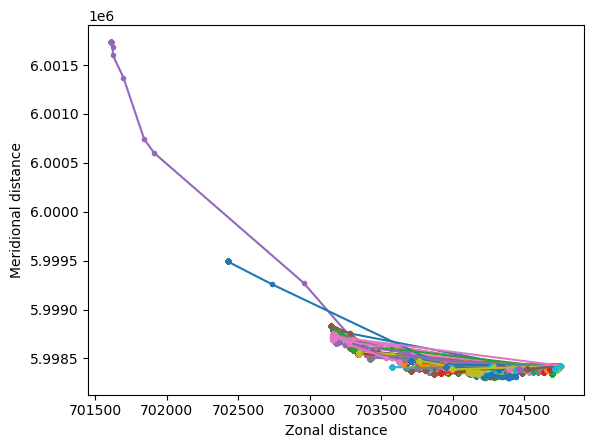

In [23]:
import matplotlib.pyplot as plt

ds = xr.open_zarr(f"output/warnow_harbor.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance")
plt.ylabel("Meridional distance")
plt.show()